In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def pi(x,lamb=0.3,k=1): #setting lambda =0.3 as required and k=1 (to basically ignore it for now)
    return k*( lamb * np.exp (-((x-80)/15)**4)  +(1-lamb) *np.exp (- ( ( x - 110 ) /15 ) **4))

plotting pi in function of x

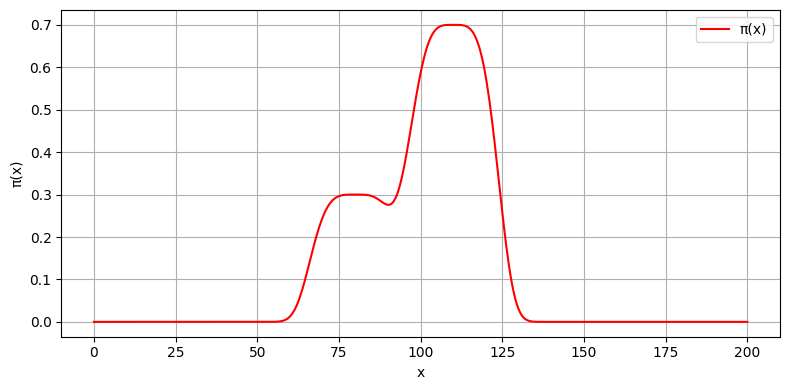

In [3]:
# Estimate M
x_vals = np.linspace(0, 200, 500)


plt.figure(figsize=(8, 4))
plt.plot(x_vals, pi(x_vals), 'r-', label='π(x)')
plt.xlabel("x")
plt.ylabel("π(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Required Conditions for Rejection Sampling


In **Rejection Sampling**, we want to sample from a target distribution $ \pi(x) $ using a proposal distribution $ q(x) $. The following two conditions must be satisfied for the algorithm to work correctly:

---

### 1. **Support Condition**

The support of the proposal distribution must cover the support of the target distribution:

$$
\text{support}(q) \supseteq \text{support}(\pi)
$$

That is, wherever $ \pi(x) > 0 $, we must have $ q(x) > 0 $.

---

### 2. **Domination Condition (Envelope Condition)**

There must exist a constant $ M > 0 $ such that:

$$
\pi(x) \leq M \cdot q(x) \quad \text{for all } x \in \text{support}(\pi)
$$

This ensures that the proposal distribution $ q(x) $ dominates the target distribution $ \pi(x) $ up to a constant scaling factor.



### ✅ Desirable Condition for Rejection Sampling



A **desirable condition** is to choose $q(x)$ such that:

$$
\frac{\pi(x)}{q(x)} \text{ is small and as constant as possible}
$$

This allows using a small $M$, which improves the **acceptance rate**.

This minimizes the number of rejected samples and improves sampling efficiency.

# Gaussian Proposal

In [4]:
# Proposal: Normal distribution
def q(x,mu,sigma,M=1): #mu, sigma, scaling factor M
    return M* ( 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2) )

I ll optimize with gradient descent starting from randomised starting points, keeping the best configurations (to avoid local minima).
From the plot we can see that the values of the optimal mu could range from 50 to 150.
I ll start with mus from 0 to 100 and M will always start=1

6436.850427965476 True 184
Step 0: Loss=6436.850428, M=3.872, mu=98.481, sigma=14.844, grads=( -287.215,0.344, 1.487)
0.2873073489160129 False 0
Step 1000: Loss=0.287307, M=90.193, mu=118.167, sigma=50.165, grads=( 0.003,-0.000, 0.002)
0.28721449103543806 False 0
Step 2000: Loss=0.287214, M=90.167, mu=118.167, sigma=50.150, grads=( 0.003,-0.000, 0.002)
0.2871215536158271 False 0
Step 3000: Loss=0.287122, M=90.140, mu=118.168, sigma=50.134, grads=( 0.003,-0.000, 0.002)
0.2870285365834207 False 0
Step 4000: Loss=0.287029, M=90.113, mu=118.168, sigma=50.118, grads=( 0.003,-0.000, 0.002)
0.28693543986442427 False 0
Step 5000: Loss=0.286935, M=90.087, mu=118.168, sigma=50.102, grads=( 0.003,-0.000, 0.002)
0.286842263385012 False 0
Step 6000: Loss=0.286842, M=90.060, mu=118.169, sigma=50.086, grads=( 0.003,-0.000, 0.002)
0.28674900707132345 False 0
Step 7000: Loss=0.286749, M=90.033, mu=118.169, sigma=50.070, grads=( 0.003,-0.000, 0.002)
0.28665567084946403 False 0
Step 8000: Loss=0.286656, 

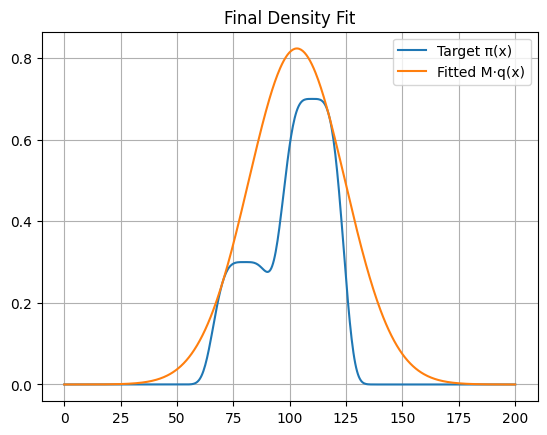


Best Fit -> Loss: 0.084296, M: 44.085, mu: 103.174, sigma: 21.353


In [5]:
# Loss function
def loss_fn(M, mu, sigma, x_vals=np.linspace(0, 200, 500), alpha=100, return_under_p=False):
    pointwise_loss = M * q(x_vals, mu, sigma) - pi(x_vals)
    under = pointwise_loss < 0
    penalized_loss = np.copy(pointwise_loss)
    penalized_loss[under] *= (-alpha * (np.sum(under)))
    mse = np.mean(np.abs(penalized_loss))
    
    if return_under_p:
        print(mse, np.any(under),np.sum(under))
    return mse

# Gradient descent optimization
def optimize(mu, sigma, M, steps, eps=1e-4, lr=0.01, x_vals=np.linspace(0, 200, 500), alpha=30000):
    for step in range(steps):
        # Numerical gradients
        dM = (loss_fn(M + eps, mu, sigma, x_vals, alpha) - loss_fn(M - eps, mu, sigma, x_vals, alpha)) / (2 * eps)
        dmu = (loss_fn(M, mu + eps, sigma, x_vals, alpha) - loss_fn(M, mu - eps, sigma, x_vals, alpha)) / (2 * eps)
        dsigma = (loss_fn(M, mu, sigma + eps, x_vals, alpha) - loss_fn(M, mu, sigma - eps, x_vals, alpha)) / (2 * eps)

        grad = np.array([dmu, dsigma, dM])
        if np.all(np.abs(grad) < 1e-4):
            print(f"Converged at step {step}: M={M:.3f}, mu={mu:.3f}, sigma={sigma:.3f}")
            break

        # Gradient descent updates
        M = np.clip(M - lr * dM, 0.1, 1000)
        mu = np.clip(mu - lr * dmu, 50, 150)
        sigma = np.clip(sigma - lr * dsigma, 0.1, 100)

        if step % 1000 == 0:
            current_loss = loss_fn(M, mu, sigma, x_vals, alpha,return_under_p=True )
            print(f"Step {step}: Loss={current_loss:.6f}, M={M:.3f}, mu={mu:.3f}, sigma={sigma:.3f}, grads=( {dM:.3f},{dmu:.3f}, {dsigma:.3f})")

    final_loss = loss_fn(M, mu, sigma, x_vals, alpha)
    return final_loss, mu, sigma, M

# Multiple random restarts
def run_optimizations(restarts=10, steps=20_000, x_vals=np.linspace(0, 200, 500), alpha=300):
    best_mu, best_sigma, best_M = 0, 1, 1
    best_loss = float('inf')
    for i in range(restarts):
        mu = np.random.choice(np.linspace(50, 150, 100))
        sigma = np.random.choice(np.linspace(1, 50, 100))
        M = 1.0
        loss, mu, sigma, M = optimize(mu, sigma, M, steps, x_vals=x_vals, alpha=alpha)
        print(f"Restart {i}: Loss={loss:.6f}, mu={mu:.3f}, sigma={sigma:.3f}, M={M:.3f}")
        if loss <= best_loss:
            best_mu, best_sigma, best_M, best_loss = mu, sigma, M, loss

    # Plot best result
    plt.plot(x_vals, pi(x_vals), label="Target π(x)")
    plt.plot(x_vals, best_M * q(x_vals, best_mu, best_sigma), label="Fitted M·q(x)")
    plt.legend()
    plt.title("Final Density Fit")
    plt.grid(True)
    plt.show()

    return best_loss, best_mu, best_sigma, best_M

best_loss, best_mu, best_sigma, best_M = run_optimizations()
print(f"\nBest Fit -> Loss: {best_loss:.6f}, M: {best_M:.3f}, mu: {best_mu:.3f}, sigma: {best_sigma:.3f}")

In [6]:
#check no points below
loss_fn(best_M, best_mu, best_sigma, x_vals=np.linspace(0, 200, 500), return_under_p=True)

0.08429561977304217 False 0


np.float64(0.08429561977304217)

from the plot we can see the gaussian efectively minimized the difference with the original curve and from the check done before we can see - points of the q are below pi.
Perfect

In [30]:

def q_optimized(x_vals):
    return q(x_vals, best_mu, best_sigma, best_M)

def simulate_q(N):
    return np.random.normal(best_mu, best_sigma, N)

def rejection_sampling(N=100_000):
    realizations = simulate_q(N)
    acceptance_prob = pi(realizations) / q_optimized(realizations)
    uniform_randoms = np.random.rand(N)
    accepted_vals = realizations[uniform_randoms < acceptance_prob]
    return accepted_vals

# Run rejection sampling
simulated_vals = rejection_sampling(N=1000_000)


/var/folders/xp/5rcl4bjn081bn67lkrq846f00000gn/T/ipykernel_99888/1585370463.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(x_vals, pi(x_vals) / np.trapz(pi(x_vals), x_vals), label='Target distribution π(x)', linewidth=2)


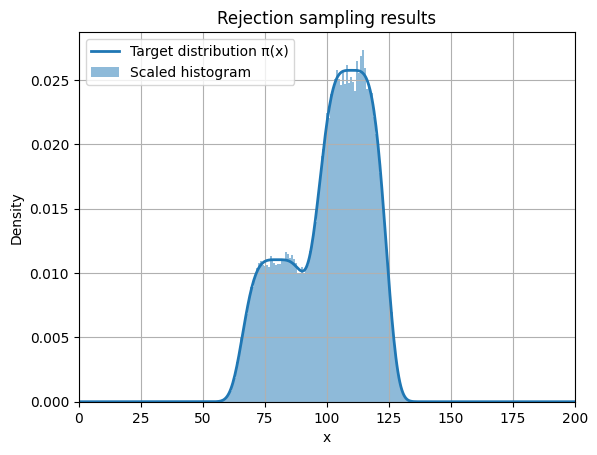

In [31]:
hist_vals, bin_edges = np.histogram(simulated_vals, bins=100, density=False)
hist_vals, bin_edges = np.histogram(simulated_vals, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot
plt.figure()
plt.bar(bin_centers, hist_vals, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='Scaled histogram')
plt.plot(x_vals, pi(x_vals) / np.trapz(pi(x_vals), x_vals), label='Target distribution π(x)', linewidth=2)
plt.legend()
plt.title("Rejection sampling results")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.xlim(0, 200)
plt.show()

it worked yay

In [28]:
payoffs = np.maximum(85 - simulated_vals, 0)
expected_payoff = np.mean(payoffs)
print(f"Estimated expected payoff: {expected_payoff:.4f}")

Estimated expected payoff: 1.9218


# part 2

In [20]:
# Gradient descent optimization
def optimize(mu, sigma, M, steps, eps=1e-4, lr=0.01, x_vals=np.linspace(0, 200, 500), alpha=30000):
    for step in range(steps):
        # Numerical gradients
        dM = (loss_fn(M + eps, mu, sigma, x_vals, alpha) - loss_fn(M - eps, mu, sigma, x_vals, alpha)) / (2 * eps)
        dsigma = (loss_fn(M, mu, sigma + eps, x_vals, alpha) - loss_fn(M, mu, sigma - eps, x_vals, alpha)) / (2 * eps)

        grad = np.array([ dsigma, dM])
        if np.all(np.abs(grad) < 1e-4):
            print(f"Converged at step {step}: M={M:.3f}, mu={mu:.3f}, sigma={sigma:.3f}")
            break

        # Gradient descent updates
        M = np.clip(M - lr * dM, 0.1, 1000)
        sigma = np.clip(sigma - lr * dsigma, 0.1, 100)

        if step % 1000 == 0:
            current_loss = loss_fn(M, mu, sigma, x_vals, alpha,return_under_p=True )
            print(f"Step {step}: Loss={current_loss:.6f}, M={M:.3f}, mu={mu:.3f}, sigma={sigma:.3f}, grads=( {dM:.3f}, {dsigma:.3f})")

    final_loss = loss_fn(M, mu, sigma, x_vals, alpha)
    return final_loss, mu, sigma, M

# Multiple random restarts
def run_optimizations(restarts=10, steps=20_000, x_vals=np.linspace(0, 200, 500), alpha=3000):
    best_mu, best_sigma, best_M = 0, 1, 1
    best_loss = float('inf')
    for i in range(restarts):
        mu = 0
        sigma = np.random.choice(np.linspace(1, 50, 100))
        M = 1.0
        loss, mu, sigma, M = optimize(mu, sigma, M, steps, x_vals=x_vals, alpha=alpha)
        print(f"Restart {i}: Loss={loss:.6f}, mu={mu:.3f}, sigma={sigma:.3f}, M={M:.3f}")
        if loss <= best_loss:
            best_mu, best_sigma, best_M, best_loss = mu, sigma, M, loss

    # Plot best result
    plt.plot(x_vals, pi(x_vals), label="Target π(x)")
    plt.plot(x_vals, best_M * q(x_vals, best_mu, best_sigma), label="Fitted M·q(x)")
    plt.legend()
    plt.title("Final Density Fit")
    plt.grid(True)
    plt.show()
    return best_loss, best_mu, best_sigma, best_M

75705.51835210691 True 188
Step 0: Loss=75705.518352, M=3.473, mu=0.000, sigma=42.717, grads=( -247.288, -14.149)
0.711424114097332 False 0
Step 1000: Loss=0.711424, M=355.034, mu=0.000, sigma=100.000, grads=( 0.002, -0.002)
0.7113671838771647 False 0
Step 2000: Loss=0.711367, M=355.010, mu=0.000, sigma=100.000, grads=( 0.002, -0.002)
0.7113102536569975 False 0
Step 3000: Loss=0.711310, M=354.986, mu=0.000, sigma=100.000, grads=( 0.002, -0.002)
0.7112533234368301 False 0
Step 4000: Loss=0.711253, M=354.962, mu=0.000, sigma=100.000, grads=( 0.002, -0.002)
0.711196393216663 False 0
Step 5000: Loss=0.711196, M=354.938, mu=0.000, sigma=100.000, grads=( 0.002, -0.002)
0.7111394629964956 False 0
Step 6000: Loss=0.711139, M=354.914, mu=0.000, sigma=100.000, grads=( 0.002, -0.002)
0.7110825327763282 False 0
Step 7000: Loss=0.711083, M=354.891, mu=0.000, sigma=100.000, grads=( 0.002, -0.002)
0.711025602556161 False 0
Step 8000: Loss=0.711026, M=354.867, mu=0.000, sigma=100.000, grads=( 0.002, -

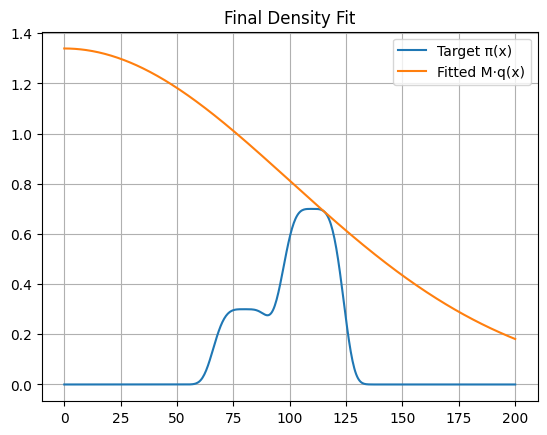


Best Fit -> Loss: 0.665491, M: 335.783, mu: 0.000, sigma: 100.000


In [21]:

best_loss, best_mu, best_sigma, best_M = run_optimizations()
print(f"\nBest Fit -> Loss: {best_loss:.6f}, M: {best_M:.3f}, mu: {best_mu:.3f}, sigma: {best_sigma:.3f}")

0.665491296047568 False 0


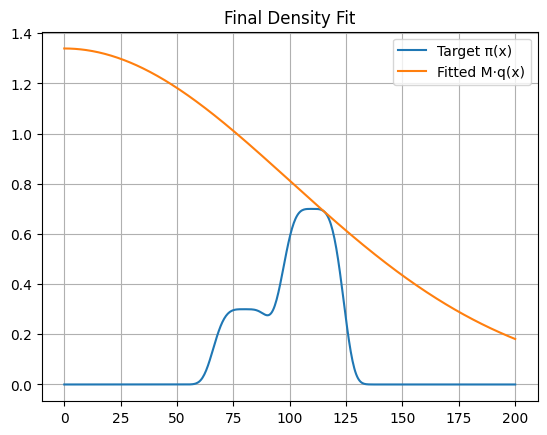

In [22]:
#check no points below
loss_fn(best_M, best_mu, best_sigma, x_vals=np.linspace(0, 200, 500), return_under_p=True)

# Plot best result
plt.plot(x_vals, pi(x_vals), label="Target π(x)")
plt.plot(x_vals, best_M * q(x_vals, best_mu, best_sigma), label="Fitted M·q(x)")
plt.legend()
plt.title("Final Density Fit")
plt.grid(True)
plt.show()

In [23]:
def metropolis_hastings_rw(pi, x0, steps=10000, sigma=best_sigma):
    samples = [x0]
    current_x = x0

    for _ in range(steps):
        proposal = current_x + np.random.normal(0, sigma)
        acceptance_ratio = pi(proposal) / pi(current_x)
        acceptance_prob = min(1, acceptance_ratio)

        if np.random.rand() < acceptance_prob:
            current_x = proposal  # Accept
        samples.append(current_x)

    return np.array(samples)

/var/folders/xp/5rcl4bjn081bn67lkrq846f00000gn/T/ipykernel_99888/3808779800.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(x_vals, pi(x_vals) / np.trapz(pi(x_vals), x_vals), label='Target distribution π(x)', linewidth=2)


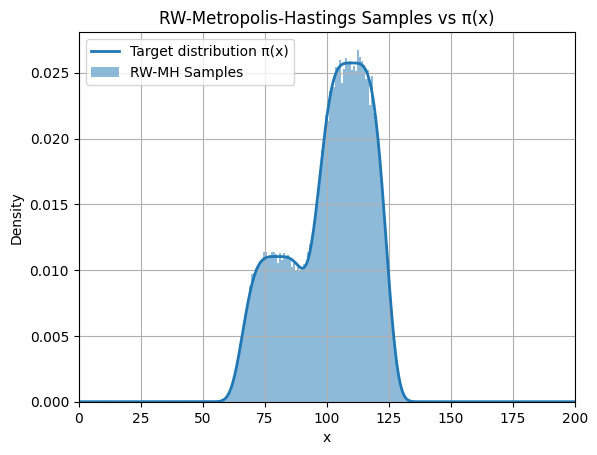

In [29]:
# Run MH sampler
samples = metropolis_hastings_rw(pi, x0=100.0, steps=1000_000, sigma=best_sigma)

hist_vals, bin_edges = np.histogram(simulated_vals, bins=100, density=False)
# Generate histogram from RW-MH samples
hist_vals, bin_edges = np.histogram(samples, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot
plt.figure()
plt.bar(bin_centers, hist_vals, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='RW-MH Samples')
plt.plot(x_vals, pi(x_vals) / np.trapz(pi(x_vals), x_vals), label='Target distribution π(x)', linewidth=2)
plt.legend()
plt.title("RW-Metropolis-Hastings Samples vs π(x)")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.xlim(0, 200)
plt.show()

In [25]:
payoffs = np.maximum(85 - samples, 0)
expected_payoff = np.mean(payoffs)
print(f"Estimated expected payoff: {expected_payoff:.4f}")

Estimated expected payoff: 1.9550
